In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxopt import ScipyMinimize
import passenger

In [2]:
counts_path = "output/igh_counts_by_base.csv"
output_prefix = "chigy_hc"
nt_base_start = 0
chigy_stop_trimmed = passenger.CHIGY_HC_STOP_TRIMMED
output_dir = "output/"
output_path_prefix = output_dir+output_prefix

Load in data, including starting to build `complete_df`, which will hold the rate estimates for all of the different methods.

In [3]:
padded_seq = "NN" + chigy_stop_trimmed + "NN"

fivemers = [padded_seq[i:i+5] for i in range(len(padded_seq) - 4)]
complete_df = pd.DataFrame({"Fivemer": fivemers})

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']
complete_df['Mutability'] = complete_df['Fivemer'].map(mutability_series)
n_frequency_df = pd.read_csv("output/igh_n_frequency.csv")
complete_df["N_frequency"] = n_frequency_df["N_frequency"]

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']

complete_df['Mutability'] = complete_df['Fivemer'].map(mutability_series)

counts_by_base = pd.read_csv(counts_path)

## Combining information across the experiments

### Substitution

Because the substitution matrix is simply a categorical on bases conditioned on a substitution, we don't have to worry about varying mutation load between the data sets.

In [4]:
by_base_dfs = dict(list(counts_by_base.groupby("nickname")))
for df in by_base_dfs.values():
    df.drop(columns=["nickname"], inplace=True)
    df.set_index("position", inplace=True)
    df.replace(-1, float("nan"), inplace=True)
    assert df.min().min() >= 0

In [5]:
pseudocount = 0.5

# total these dfs
by_base_df = sum(df for df in by_base_dfs.values())

by_base_df += pseudocount
# replace all nans by 0
by_base_df = by_base_df.fillna(0)
by_base_df = by_base_df.div(by_base_df.sum(axis=1), axis=0)
by_base_df.to_csv(output_path_prefix+"_substitution.csv")
by_base_df

,A,C,G,T
position,,,,
0,0.333333,0.333333,0.000000,0.333333
1,0.000000,0.333333,0.333333,0.333333
2,0.677903,0.280899,0.000000,0.041199
3,0.636364,0.333333,0.000000,0.030303
4,0.614815,0.259259,0.125926,0.000000
...,...,...,...,...
332,0.147541,0.000000,0.180328,0.672131
333,0.011236,0.415730,0.573034,0.000000
334,0.032258,0.000000,0.483871,0.483871


### Mutability

Let $i$ index the sites, and $j$ represent the experiment.
We will use the notation:

* $n_{ij}$: the number of mutations observed at site $i$ in experiment $j$
* $r_i$: the rate of mutation at site $i$
* $\lambda_j$: the Poisson offset for experiment $j$ representing the length of the period of affinity maturation
* $s_j$: the sequencing depth of experiment $j$

We will model

$$
n_{ij} \sim \operatorname{Pois}(r_i \lambda_j s_j)
$$

The log likelihood for this model across all sites and experiments will be 

$$
C + \sum_{i,j} \left[n_{ij} \log(r_i \lambda_j s_j) - r_i \lambda_j s_j \right]
$$

In [6]:
by_site_df = pd.DataFrame({name: df.sum(axis=1, skipna=True) for name, df in by_base_dfs.items()})
by_site_df

,5_IgG,5_IgM,5_S1,6A_S2,6_IgG,6_IgM,7B_S3,7_IgG,7_IgM
position,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,40.0,2.0,8.0,9.0,17.0,6.0,12.0,25.0
3,3.0,6.0,0.0,2.0,0.0,1.0,1.0,0.0,2.0
4,16.0,21.0,0.0,4.0,0.0,8.0,2.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...
332,1.0,5.0,1.0,3.0,2.0,7.0,1.0,2.0,7.0
333,7.0,9.0,1.0,11.0,3.0,5.0,3.0,0.0,4.0
334,2.0,2.0,1.0,1.0,0.0,3.0,2.0,0.0,3.0


In [7]:
def rarely_mutated_positions(by_site_df):
    column_sums = by_site_df.sum(axis=1)
    sorted_by_site_df = by_site_df.loc[column_sums.sort_values(ascending=False).index]
    return sorted_by_site_df.tail(10)

rarely_mutated_positions(by_site_df)

,5_IgG,5_IgM,5_S1,6A_S2,6_IgG,6_IgM,7B_S3,7_IgG,7_IgM
position,,,,,,,,,
78,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
82,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
75,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
320,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
read_counts_df = pd.read_csv("output/igh_read_counts.csv")
assert (read_counts_df["nickname"] == by_site_df.columns).all()
read_counts_df

,nickname,read_count
0,5_IgG,3449
1,5_IgM,6578
2,5_S1,722
3,6A_S2,1749
4,6_IgG,2263
5,6_IgM,4336
6,7B_S3,1567
7,7_IgG,1645
8,7_IgM,4590


We're going to use a pseudocount of 1, but split up among the data sets according to read counts.

In [9]:
read_counts_normalized = read_counts_df["read_count"] / read_counts_df["read_count"].sum()
by_site_df += read_counts_normalized.values[None, :]

rarely_mutated_positions(by_site_df)

,5_IgG,5_IgM,5_S1,6A_S2,6_IgG,6_IgM,7B_S3,7_IgG,7_IgM
position,,,,,,,,,
78,0.12822,1.244544,0.026841,0.065021,0.08413,2.161196,0.058255,0.061155,1.170638
82,0.12822,0.244544,0.026841,0.065021,0.08413,2.161196,0.058255,0.061155,2.170638
75,0.12822,2.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,1.170638
19,1.12822,2.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
302,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,1.170638
320,0.12822,1.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
195,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
306,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
1,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638


In [10]:
read_counts = jnp.array(read_counts_df["read_count"])
site_count = by_site_df.shape[0]
experiment_count = by_site_df.shape[1]

def neg_log_likelihood(params, n_ij, s_j):
    log_r_i, log_lambda_j = params[:site_count], params[site_count:]
    lambda_j = jnp.exp(log_lambda_j)
    # Here we are applying softmax to exponentiate then normalize.
    r_i = jax.nn.softmax(log_r_i)
    expected = r_i[:, None] * lambda_j[None, :] * s_j[None, :]
    ll = n_ij * jnp.log(expected) - expected
    return -jnp.sum(ll)

n_ij = jnp.array(by_site_df)
initial_params = jnp.log(jnp.ones(site_count + experiment_count))

neg_log_likelihood(initial_params, n_ij, read_counts)

Array(-112377.68297974, dtype=float64)

In [11]:
# Set up the optimizer
optimizer = ScipyMinimize(fun=neg_log_likelihood, method='BFGS')
result = optimizer.run(initial_params, n_ij=n_ij, s_j=read_counts)

# Extract the optimized parameters
opt_params = result.params
r_i_opt = jax.nn.softmax(opt_params[:site_count])
lambda_j_opt = jnp.exp(opt_params[site_count:])

opt_likelihood = neg_log_likelihood(opt_params, n_ij, read_counts)

complete_df["fit_rate"] = r_i_opt

pd.DataFrame({"nickname": read_counts_df["nickname"], "mutation_load": lambda_j_opt})

,nickname,mutation_load
0,5_IgG,1.782027
1,5_IgM,2.340136
2,5_S1,2.699509
3,6A_S2,2.420762
4,6_IgG,1.910451
5,6_IgM,2.177427
6,7B_S3,2.604105
7,7_IgG,1.923167
8,7_IgM,2.264598


In [12]:
by_site_df.loc[complete_df['fit_rate'] <= 1e-4]

,5_IgG,5_IgM,5_S1,6A_S2,6_IgG,6_IgM,7B_S3,7_IgG,7_IgM
position,,,,,,,,,
0,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
1,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
19,1.12822,2.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
75,0.12822,2.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,1.170638
78,0.12822,1.244544,0.026841,0.065021,0.08413,2.161196,0.058255,0.061155,1.170638
82,0.12822,0.244544,0.026841,0.065021,0.08413,2.161196,0.058255,0.061155,2.170638
195,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638
302,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,1.170638
306,0.12822,0.244544,0.026841,0.065021,0.08413,0.161196,0.058255,0.061155,0.170638


In [13]:
fit_rate_sum = complete_df["fit_rate"].sum(skipna=True)
complete_df["rate"] = complete_df["fit_rate"]/fit_rate_sum
complete_df["normed_s5f"] = complete_df["Mutability"] / sum(complete_df["Mutability"])

complete_df = pd.concat([complete_df, by_base_df * complete_df["rate"].values[:, None]], axis=1)
complete_df.index = complete_df.index + nt_base_start
complete_df

,Fivemer,Mutability,N_frequency,fit_rate,rate,normed_s5f,A,C,G,T
0,NNGAG,0.000555,0.000000,0.000017,0.000017,0.001851,0.000006,0.000006,0.000000,0.000006
1,NGAGG,0.000506,0.000000,0.000017,0.000017,0.001690,0.000000,0.000006,0.000006,0.000006
2,GAGGT,0.000578,0.000149,0.002249,0.002249,0.001930,0.001525,0.000632,0.000000,0.000093
3,AGGTG,0.002178,0.000186,0.000271,0.000271,0.007267,0.000172,0.000090,0.000000,0.000008
4,GGTGC,0.000110,0.000112,0.001133,0.001133,0.000368,0.000697,0.000294,0.000143,0.000000
...,...,...,...,...,...,...,...,...,...,...
332,TCCTC,0.000950,0.000149,0.000507,0.000507,0.003168,0.000075,0.000000,0.000091,0.000341
333,CCTCA,0.000071,0.000520,0.000744,0.000744,0.000237,0.000008,0.000309,0.000426,0.000000
334,CTCAG,0.000572,0.000074,0.000254,0.000254,0.001909,0.000008,0.000000,0.000123,0.000123
335,TCAGN,0.000289,0.000223,0.000863,0.000863,0.000963,0.000000,0.000193,0.000343,0.000327


In [14]:
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt.csv", columns=["Fivemer", "A", "C", "G", "T"])
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt_extras.csv", columns=["Fivemer", "rate", "normed_s5f", "A", "C", "G", "T"])

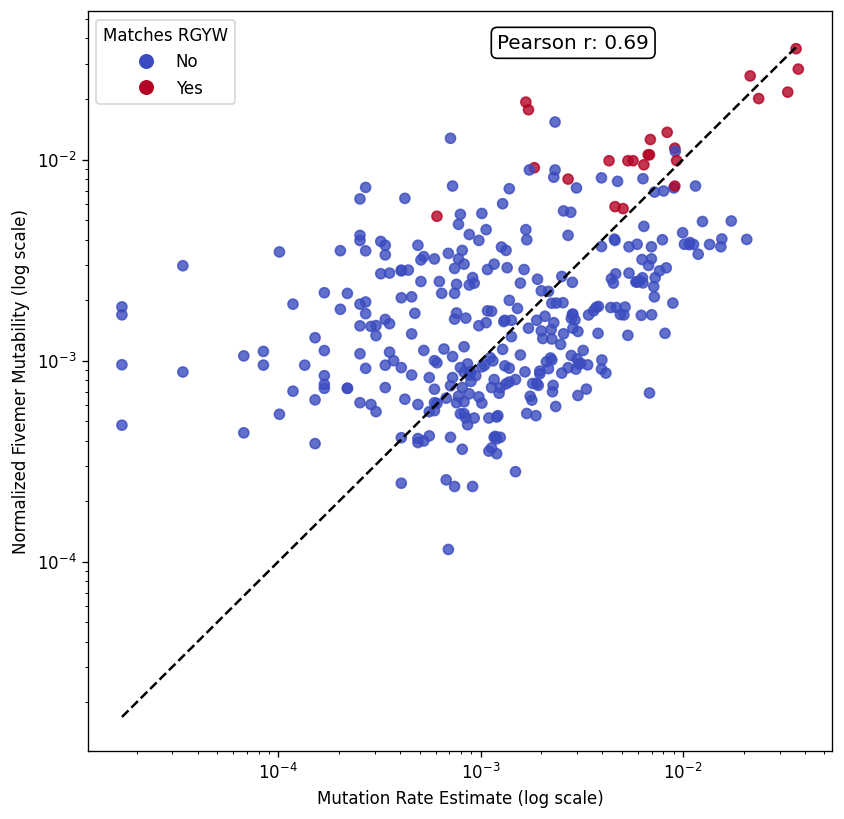

In [15]:
# Apply the matches_RGYW function to the 'Fivemer' column
complete_df['matches_RGYW'] = complete_df['Fivemer'].apply(passenger.matches_RGYW)

passenger.plot_mutation_rate_vs_normed_s5f(complete_df)

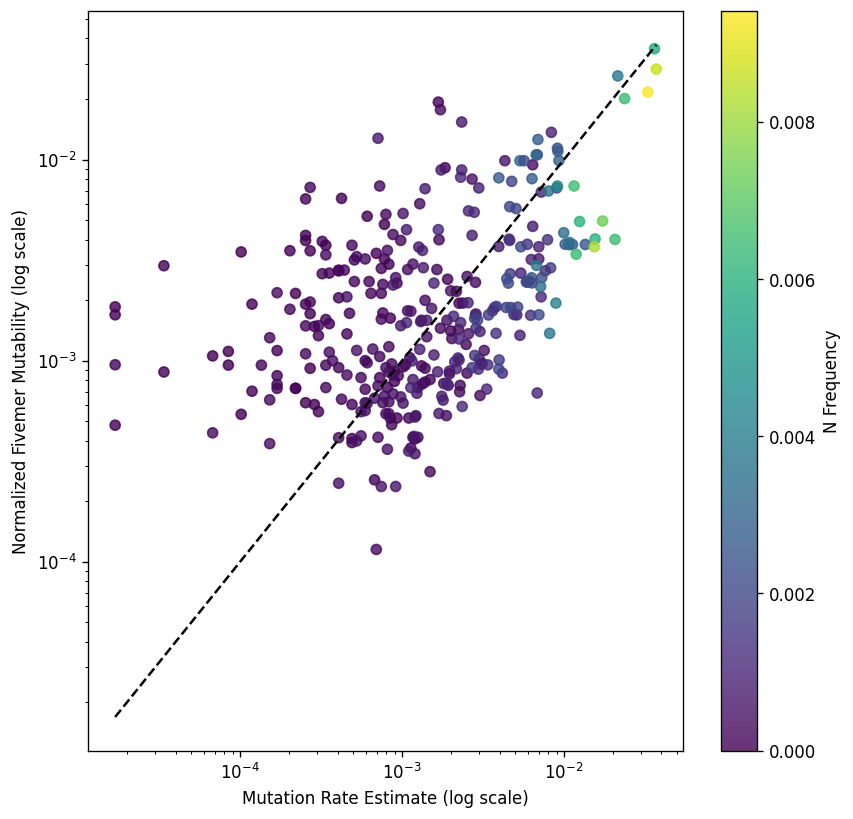

In [16]:
def plot_mutation_rate_vs_normed_s5f_showing_N(df):
    plt.figure(figsize=(8, 8))  # Square aspect ratio
    scatter = plt.scatter(
        df["rate"], df["normed_s5f"], c=df["N_frequency"], cmap="viridis", alpha=0.8
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Mutation Rate Estimate (log scale)")
    plt.ylabel("Normalized Fivemer Mutability (log scale)")

    # Add a color bar to the plot
    plt.colorbar(scatter, label="N Frequency")

    # Add y=x line
    min_limit = min(df["rate"].min(), df["normed_s5f"].min())
    max_limit = max(df["rate"].max(), df["normed_s5f"].max())
    plt.plot([min_limit, max_limit], [min_limit, max_limit], "k--")  # Add x=y line

    plt.show()

plot_mutation_rate_vs_normed_s5f_showing_N(complete_df)
